# Analysis Demo

In [1]:
# Disable warnings for prettier notebook
import warnings
warnings.filterwarnings("ignore")

In [2]:
from pathlib import Path
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import torch

import anndata as ad
import scanpy as sc
import squidpy as sq

In [3]:
from popari import pl, tl
from popari.model import load_trained_model

## Load trained model

In [4]:
data_directory = Path("/work/magroup/shahula/spatiotemporal_transcriptomics_integration/data/STARmapPlus/SCP1375/")
demo = load_trained_model(data_directory / f"hierarchical_results", verbose=0, context=dict(device="cuda:1", dtype=torch.float64)) # Replace with path to your trained model

[2023/09/08 17:44:38]	 Reloading level 0
[2023/09/08 17:44:38]	 Reloading level 1


### Load from MLflow

In [18]:
from popari.mlflow.util import load_from_mlflow_run

If you used the MLflow to run a grid search for Popari hyperparameters, you can load your favorite run using the `load_from_mlflow_run` function.

## Postprocessing

First, we Z-score normalize the Popari embeddings; this ensures that the dimensions of the latent space are weighted equally for downstream tasks such as clustering.  

In [5]:
tl.preprocess_embeddings(demo, level=1, normalized_key="normalized_X")

We can then cluster the embeddings to uncover cell types or other spatially-coherent groupings of the samples. The clustering can either be done separately for each FOVs (default), or jointly for all datasets (using `joint=True`).

In [6]:
tl.leiden(demo, level=1, joint=True, use_rep="normalized_X")

We can also compute the empirical correlation between the learned embeddings `X`, and these results can later be compared/contrasted against the learned spatial affinities.

In [7]:
tl.compute_empirical_correlations(demo, level=1, feature="X")

## Plotting

### Plotting clustering results

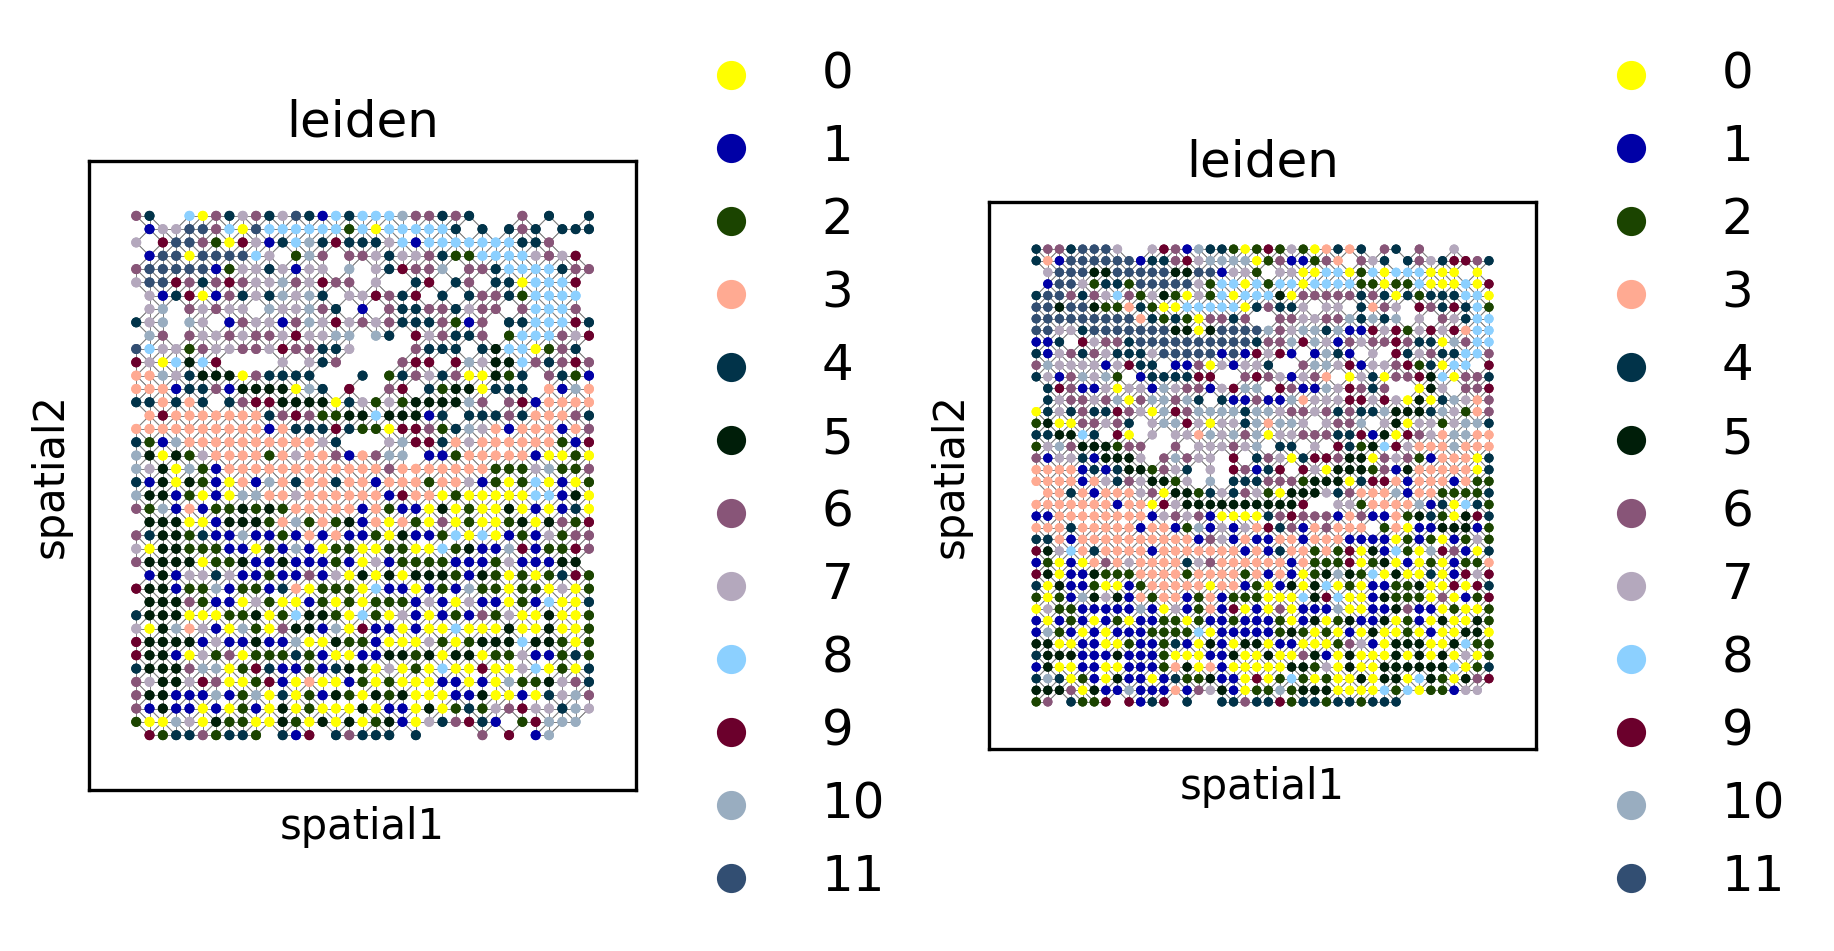

In [8]:
fig, axes = plt.subplots(1, 2, constrained_layout=True, dpi=300)
pl.in_situ(demo, color="leiden", level=1, legend_fontsize="large", axes=axes)

### Comparing empirical correlations to learned affinities

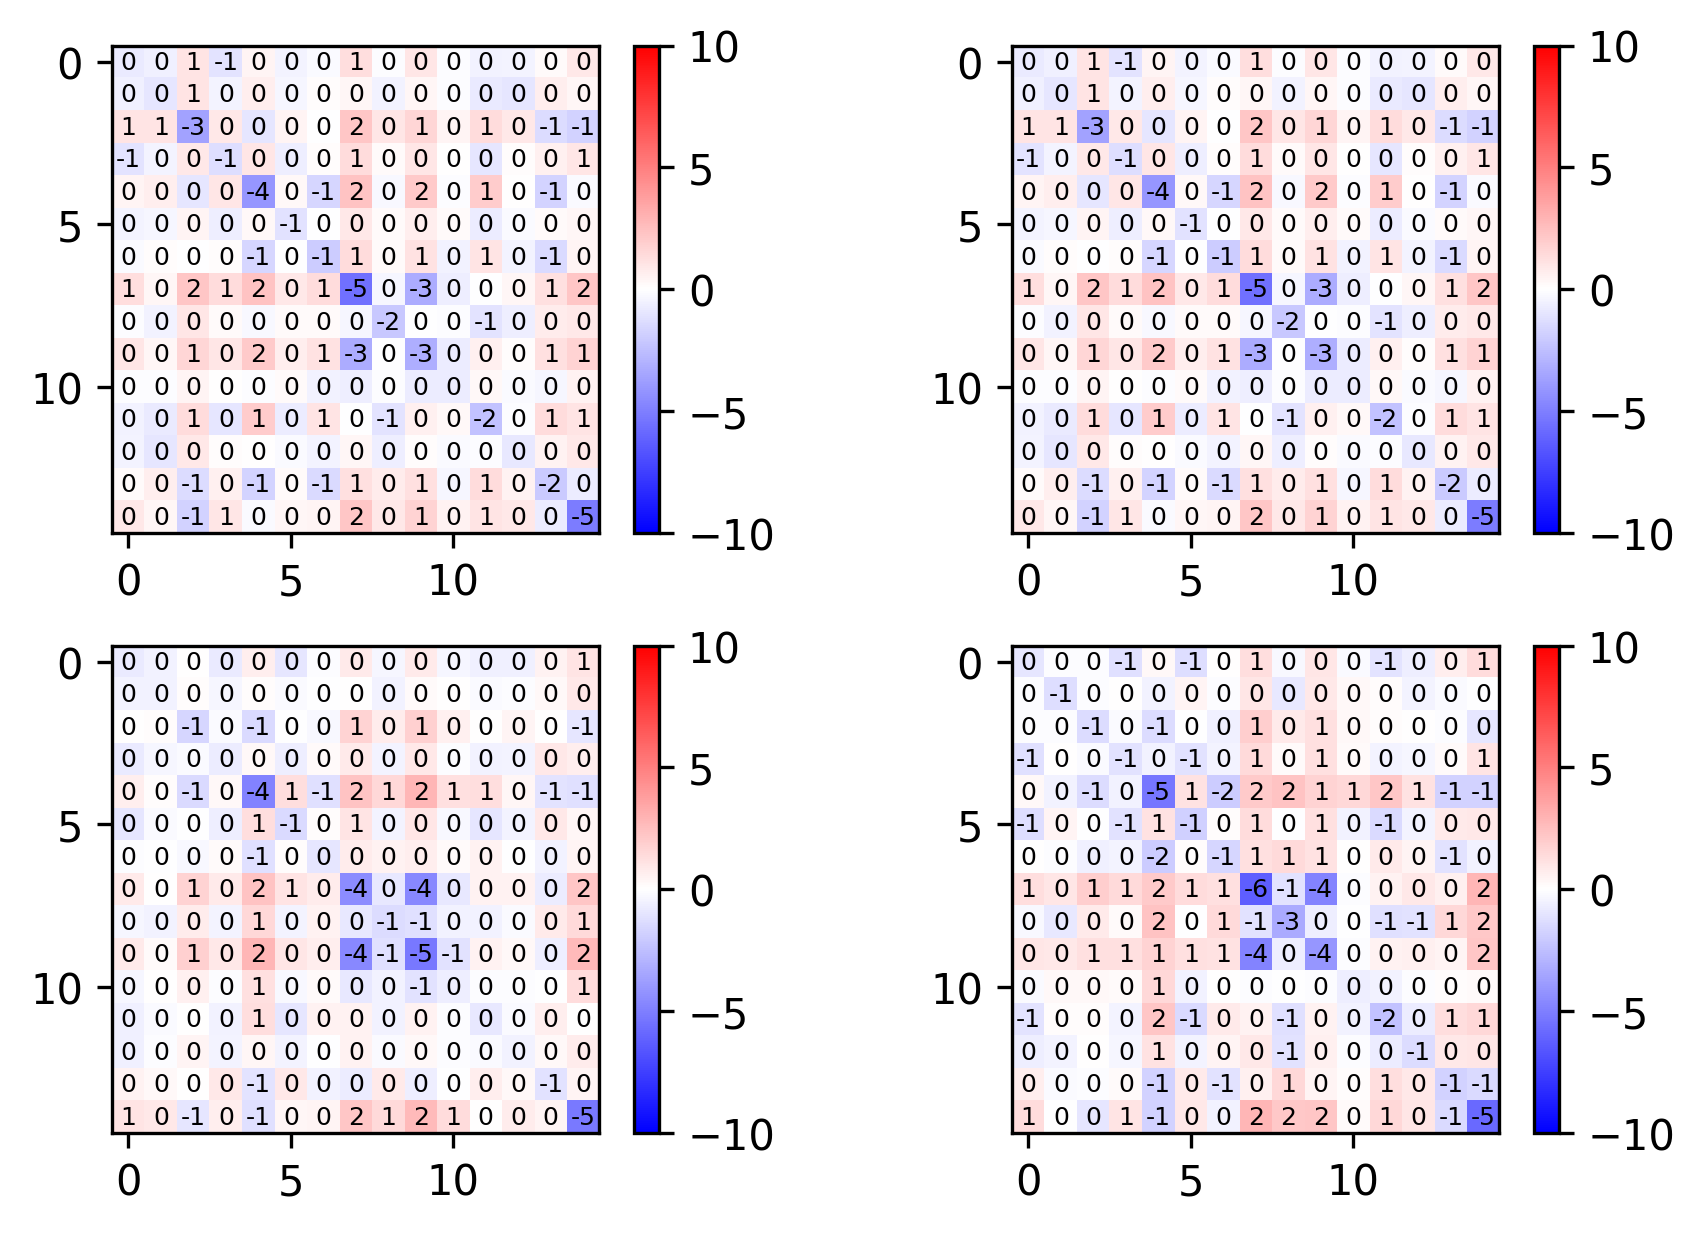

In [9]:
fig, axes = plt.subplots(2, 2, constrained_layout=True, dpi=300)
pl.multireplicate_heatmap(demo, level=1, label_values=True, label_font_size=6, uns="Sigma_x_inv", aspect=1, cmap="bwr", vmin=-10, vmax=10, axes=axes[0])
pl.multireplicate_heatmap(demo, level=1, label_values=True, label_font_size=6, uns="empirical_correlation", aspect=1, cmap="bwr", vmin=-10, vmax=10, axes=axes[1])

### Plot all metagenes _in-situ_

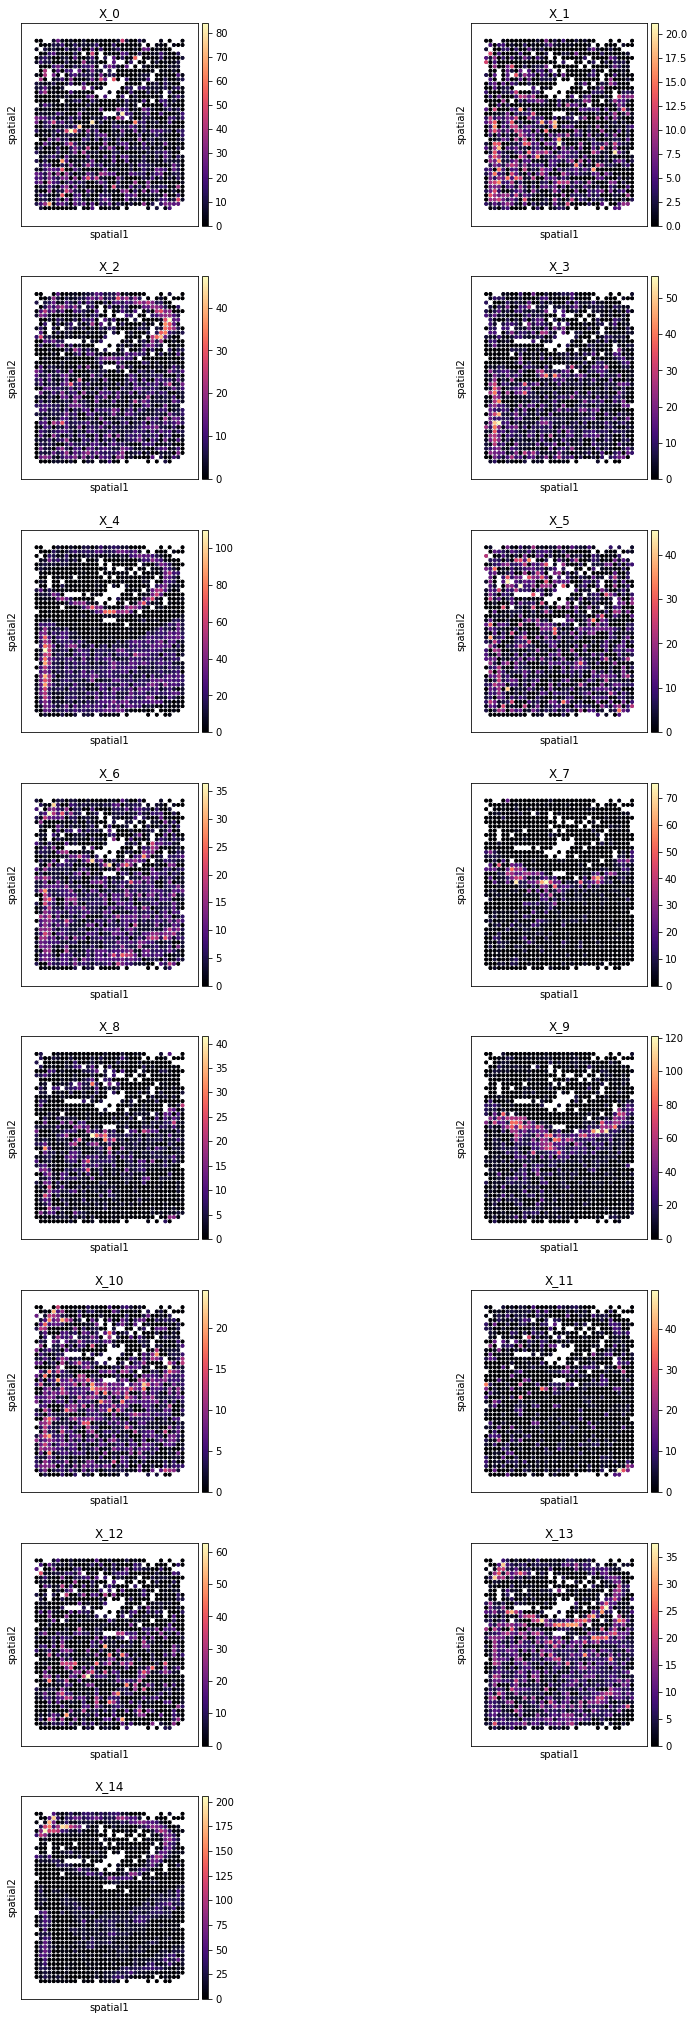

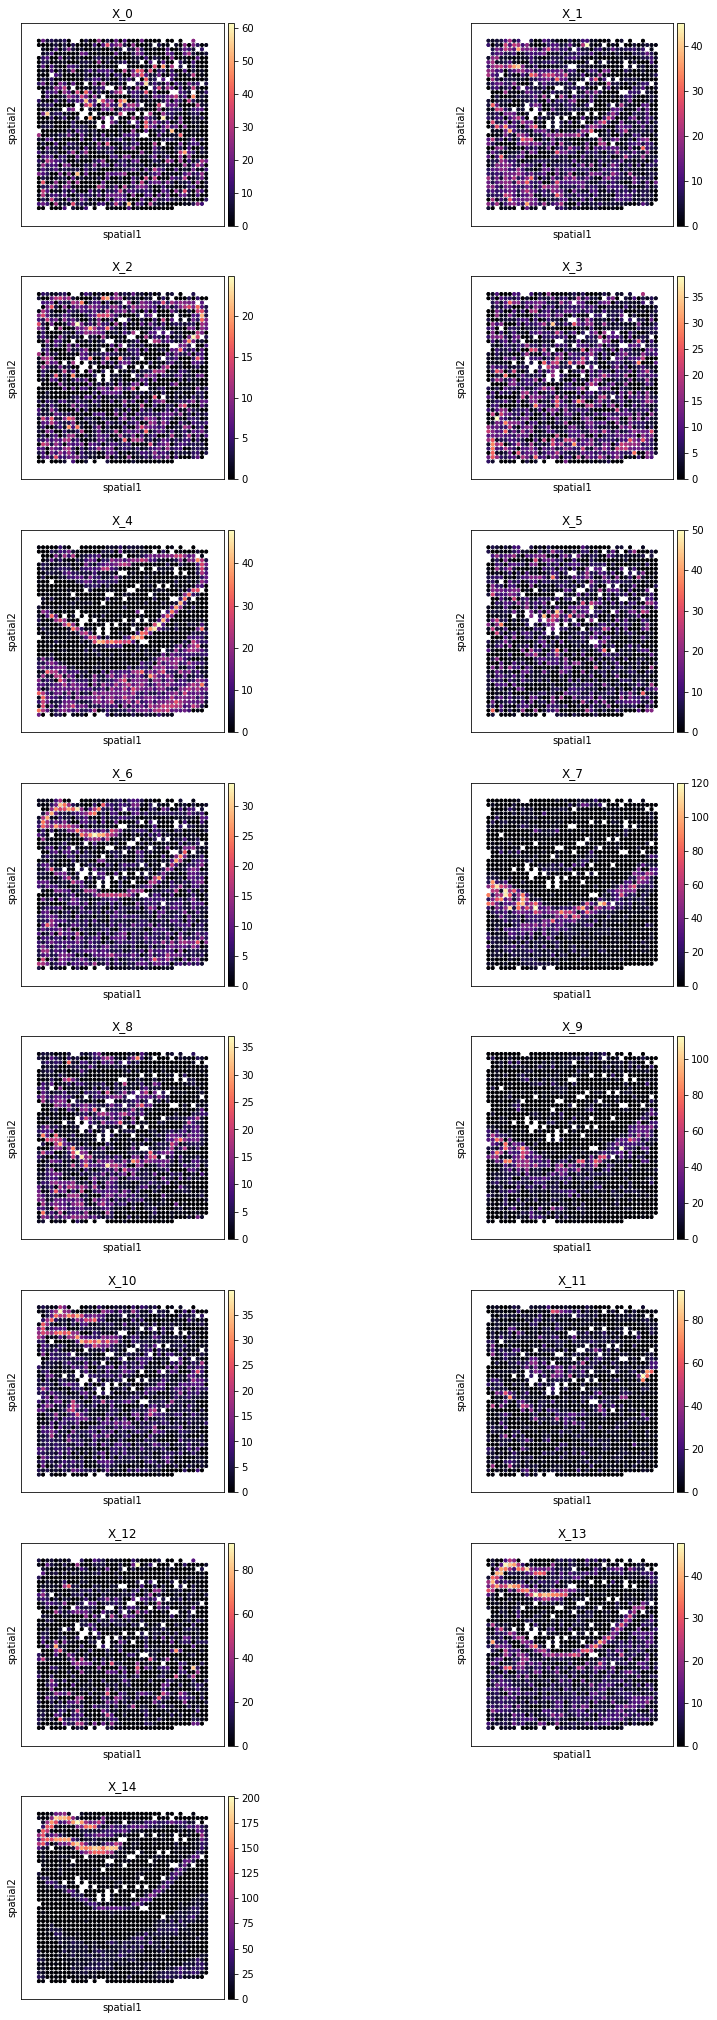

In [10]:
pl.all_embeddings(demo, level=1, size=30, cmap="magma")

```{note}
All data (including input gene expression data, spatial coordinates, learned embeddings/metagenes/spatial affinities) can be found within the `popari.model.Popari.datasets` attribute. You can build your own analysis functions that access these data; see `popari.analysis` and `popari._dataset_utils` for examples.
```

## Hierarchical Analysis

Because we used the hierarchical setting, we can repeat our analyses at higher resolution of the data. This can be accomplished using the `level` parameter. Most of the analysis/plotting functions accept this parameter, and it can be used to indicate which hierarchical analysis the function should be computed at. `level=0` indicates the highest (original) resolution, whereas `level=model.hierarchical_levels - 1` indicates the lowest resolution.

In [11]:
demo.hierarchical_levels

2

Before any high resolution analysis, we ensure that the embeddings at the higher resolutions are fully superresolved.

In [12]:
demo.superresolve(n_epochs=10000, tol=1e-6)

In [13]:
# Postprocessing
tl.preprocess_embeddings(demo, level=0, normalized_key="normalized_X")
tl.leiden(demo, joint=True, level=0, use_rep="normalized_X")
tl.compute_empirical_correlations(demo, level=0, feature="X")

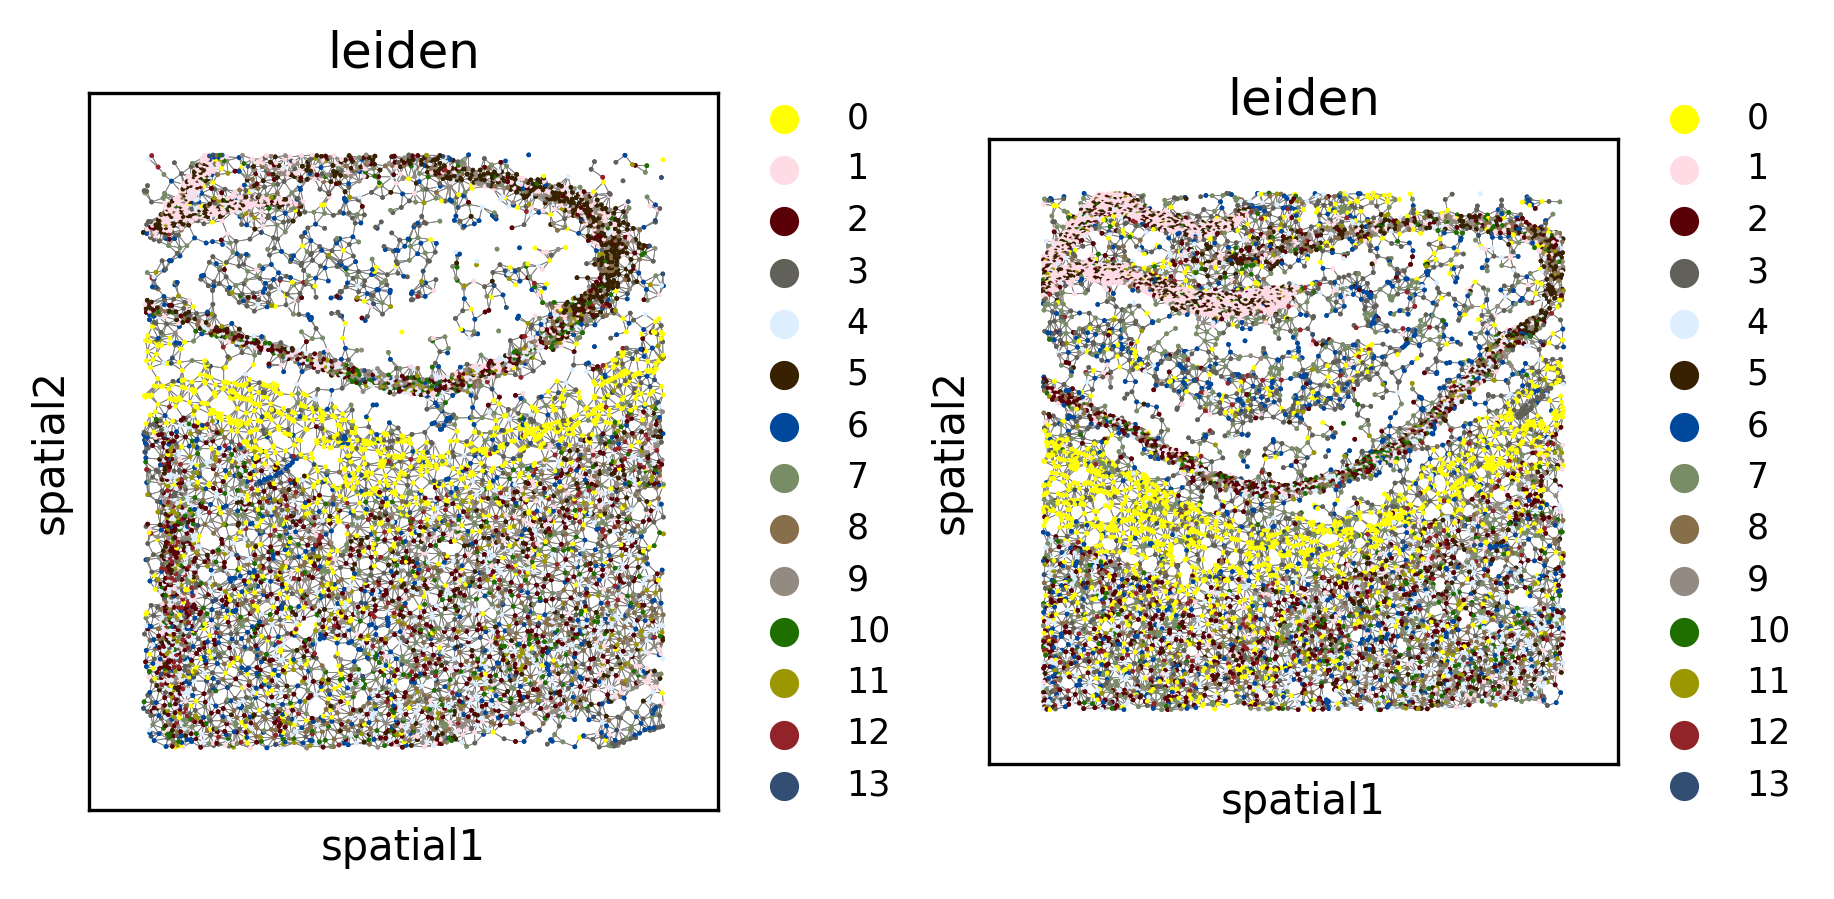

In [14]:
# Plot in-situ high resolution clusters
fig, axes = plt.subplots(1, 2, constrained_layout=True, dpi=300)
pl.in_situ(demo, level=0, color="leiden", legend_fontsize="small", edgecolors='none', size=5, axes=axes)

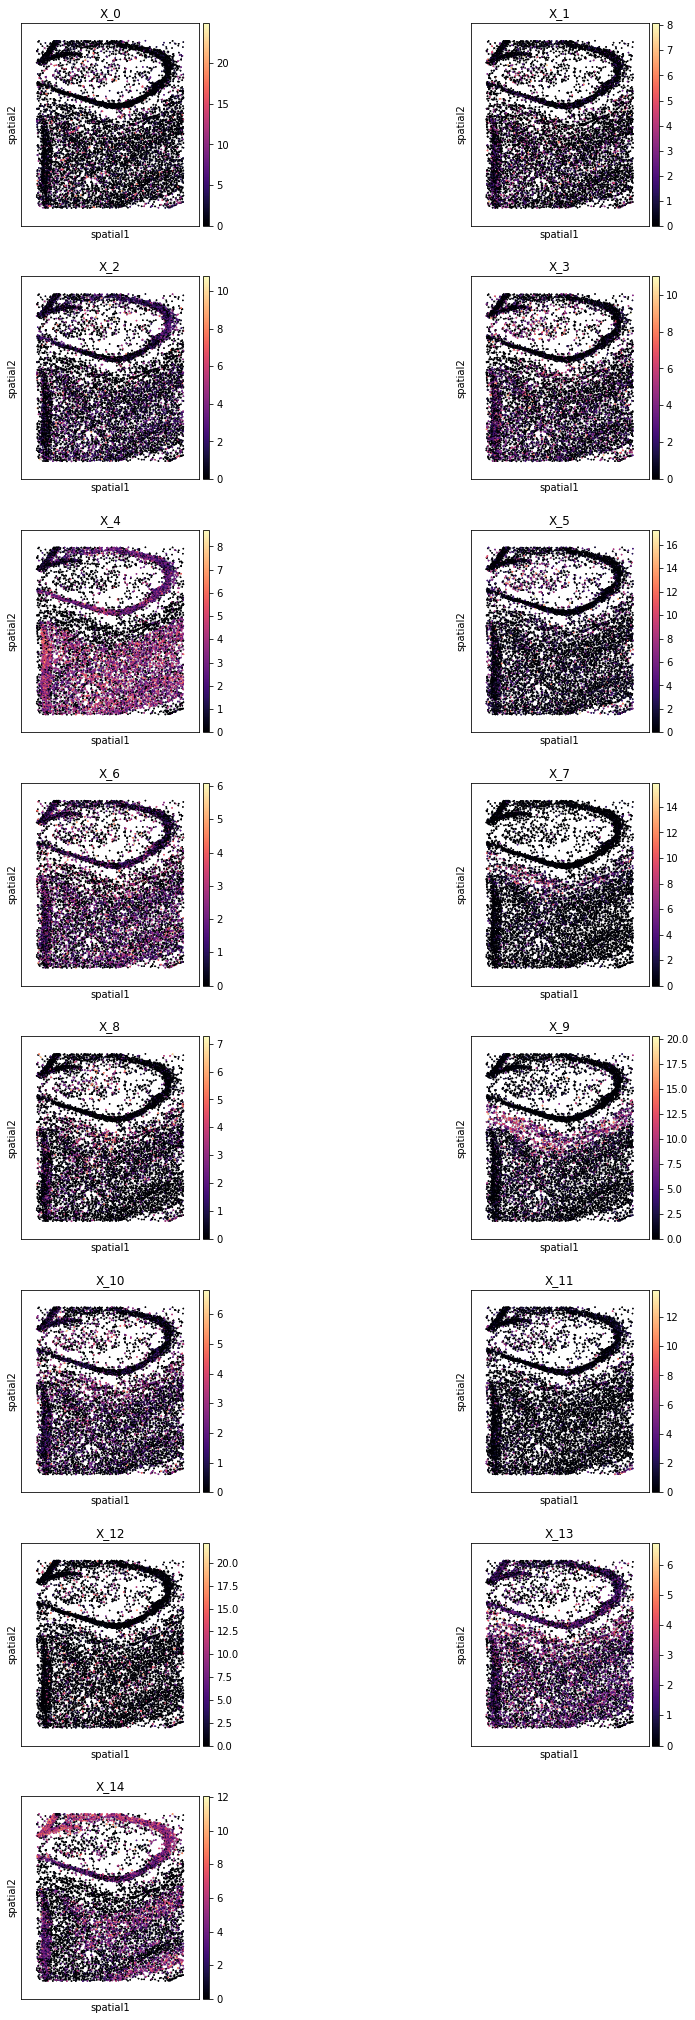

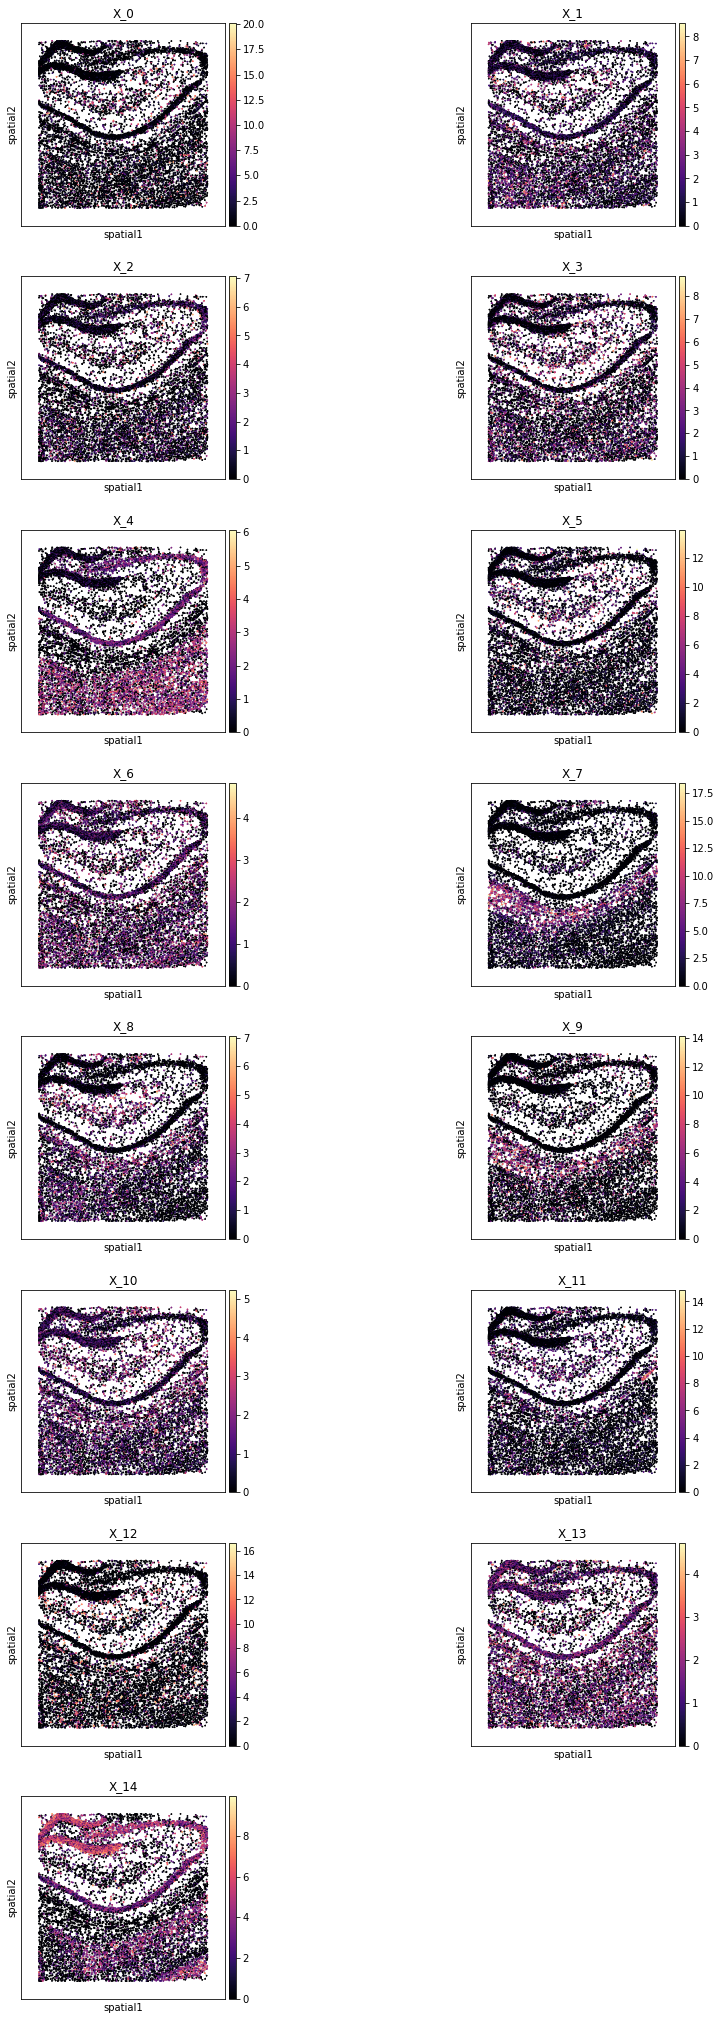

In [15]:
# Plot in-situ high resolution metagene embeddings
pl.all_embeddings(demo, level=0, size=10, edgecolors='none', cmap="magma")

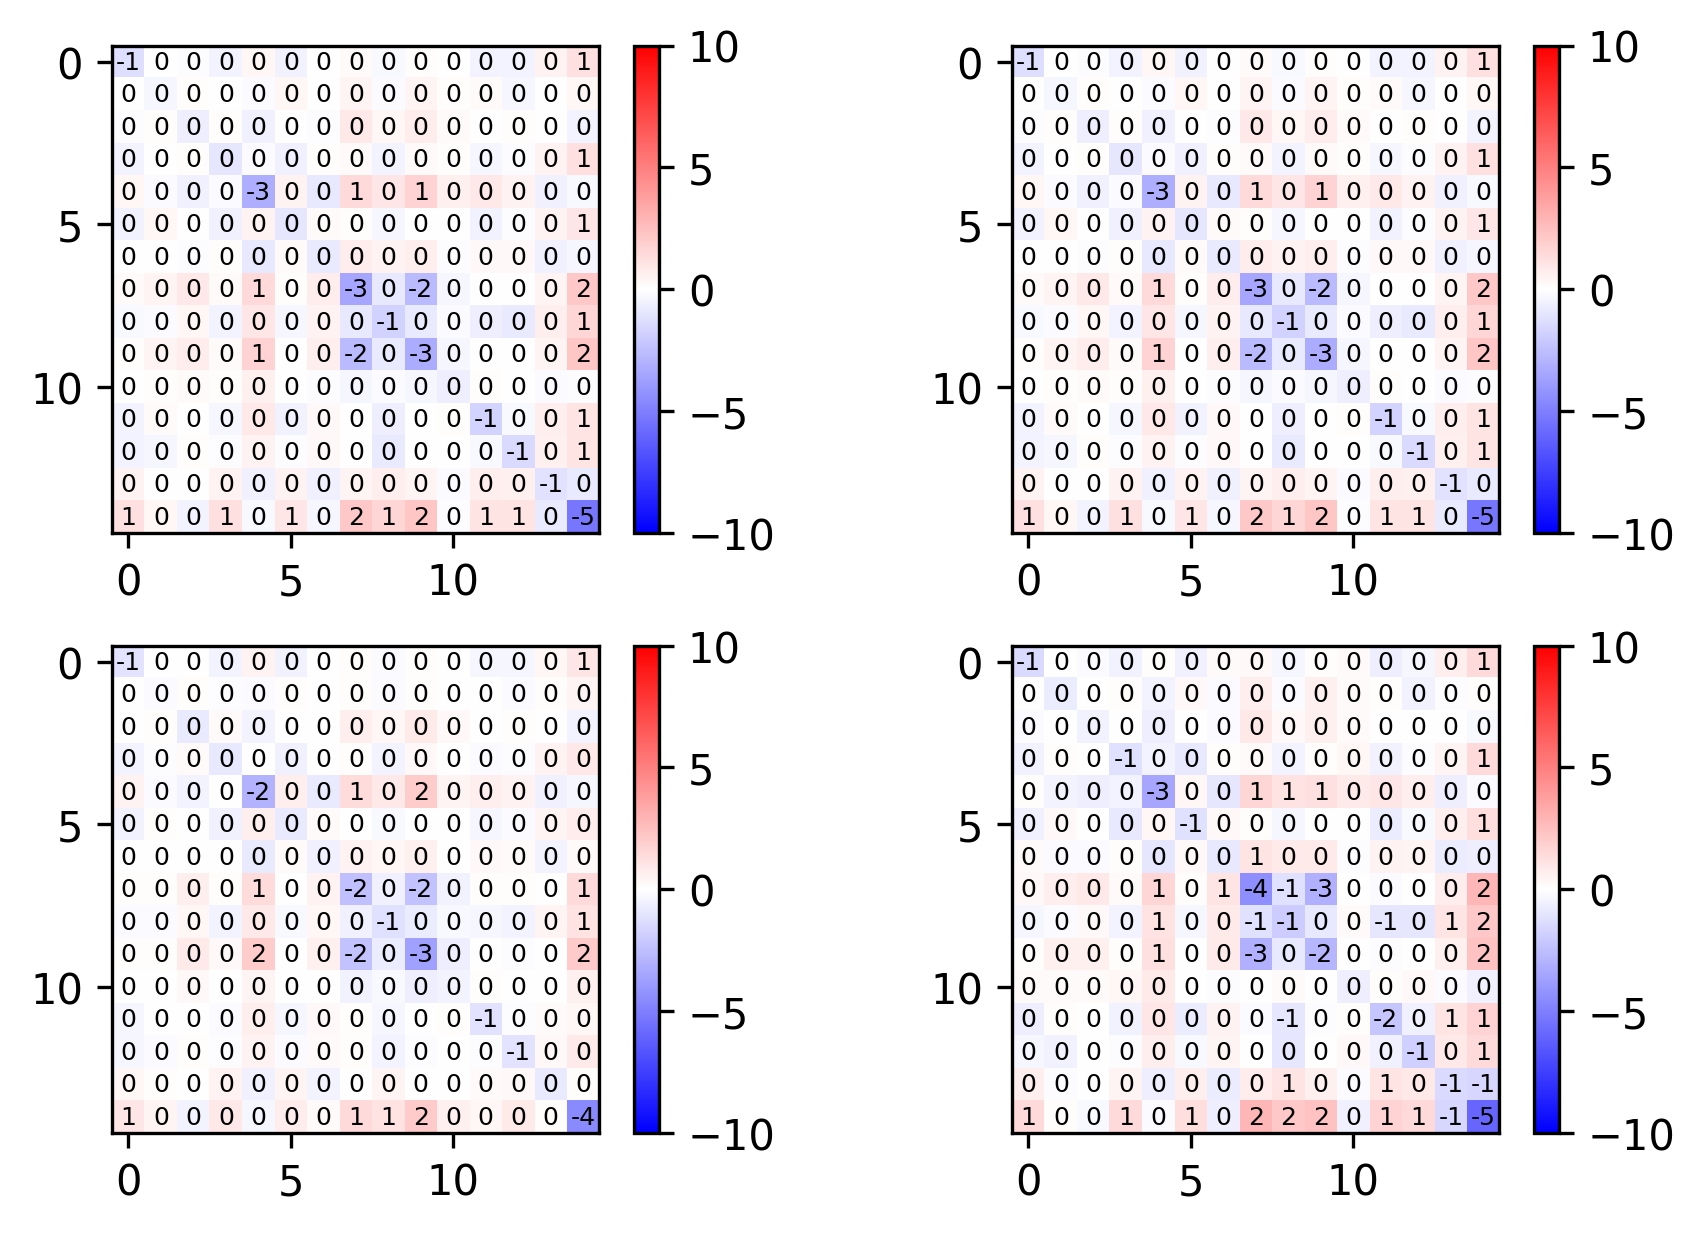

In [16]:
fig, axes = plt.subplots(2, 2, constrained_layout=True, dpi=300)
pl.multireplicate_heatmap(demo, level=0, label_values=True, label_font_size=6, uns="Sigma_x_inv", aspect=1, cmap="bwr", vmin=-10, vmax=10, axes=axes[0])
pl.multireplicate_heatmap(demo, level=0, label_values=True, label_font_size=6, uns="empirical_correlation", aspect=1, cmap="bwr", vmin=-10, vmax=10, axes=axes[1])

### Custom plotting function

You can create your own plotting functions using the `popari._dataset_utils._broadcast_operator` function.

In [17]:
# TODO